In [ ]:
import plotly   # импортируем важные библиотеки, которые будем использовать дальше
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.offline as pyo
from pytrends.request import TrendReq
import pytrends
import pandas as pd
import configparser
import logging
from logging import Formatter
from logging.handlers import RotatingFileHandler
import mysql.connector
import matplotlib.pyplot as plt
import time
import geopandas as gpd
import os
import datetime as dt

In [ ]:
# убираем надоедливые предупреждение в ноутбуке
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Как уже было сказано, при парсинге Селениумом Яндекс с течением времени начал банить, поэтому спарсить удалось не очень много.
# Однако можно изучить сохранившиеся при ранней работе csv файлы.

In [ ]:
# Здесь мы читаем настройки из файла и инициализиурем объект парсера настроек
config = configparser.RawConfigParser()
config.read('conf.ini', encoding='utf-8')

try:
# Здесь мы инициализируем объект логгера и задаем ему настройки
    logger = logging.getLogger('logger')
    logger.setLevel(config.get('LOGGING', 'level'))
    handler = RotatingFileHandler(config.get('LOGGING', 'filename'), maxBytes=1000000, backupCount=10)
    formatter = Formatter(fmt='[%(asctime)s] %(levelname)s: %(message)s', datefmt='%Y-%m-%d %H:%M:%S', )
    handler.setFormatter(formatter)
    logger.addHandler(handler)

    # Получаем данные из файла настроек
    yandex_data = config.get('FOLDERS', 'yandex_data')  # каталог для исходящих данных
    google_data = config.get('FOLDERS', 'google_data')  # каталог для архивного хранения исходящих данных
    yandex_login = config.get('TOKENS', 'yandex_log')
    yandex_password = config.get('TOKENS', 'yandex_pass')
    selenium_executor = config.get('FOLDERS', 'selenium_executor')  # каталог с входными файлами
    create_db_sql = config.get('SQL', 'create_db')  # путь до большого скрипта, необходимого при загрузке
    unis = config.get('SQL', 'unis')
    # Строки подключения к базам данных
    cnx = mysql.connector.connect(
        host=config.get('DB', 'host'),
        user=config.get('DB', 'user'),
        password=config.get('DB', 'sql_pass'),
        database="webscrapper"
    )  # конфиг для подключения к базам данных
except Exception as e:
    print('can not get params from ini, exit: {ex}'.format(ex=str(e)))

In [ ]:
# Считываем файлы Яндекса (те, что успели спарсить Селениумом)
yandex_harvard = pd.read_csv(f"{yandex_data}{os.sep}harvard.csv") #для Гарварда
yandex_synergy = pd.read_csv(f"{yandex_data}{os.sep}университет синергия.csv") #для Синергии

In [ ]:
# Смотрим на полученный файл. Абсолютное значение в количестве запросов.
yandex_synergy

,Период,Абсолютное,Относительное
0,11.04.2022-17.04.2022,11752.0,"0,000004093262"
1,18.04.2022-24.04.2022,11007.0,"0,000003876341"
2,25.04.2022-01.05.2022,9328.0,"0,000003463586"
3,02.05.2022-08.05.2022,7131.0,"0,000002803944"
4,09.05.2022-15.05.2022,8705.0,"0,000003175733"
5,16.05.2022-22.05.2022,10950.0,"0,000003798015"
6,23.05.2022-29.05.2022,12654.0,"0,000004564023"
7,30.05.2022-05.06.2022,12856.0,"0,000004969486"
8,06.06.2022-12.06.2022,14084.0,"0,000005599495"
9,13.06.2022-19.06.2022,16265.0,"0,000006468331"


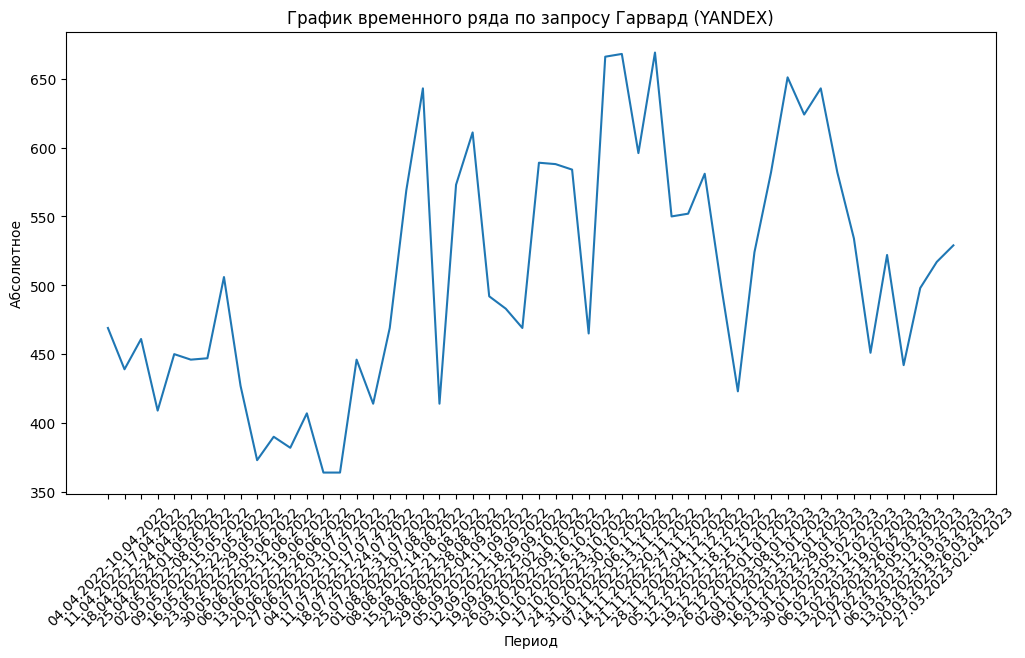

In [ ]:
# рисуем график для Гарварда
plt.figure(figsize=(12, 6))
plt.plot(yandex_harvard['Период'], yandex_harvard['Абсолютное'])
# меняем угол, чтобы все даты вместились
plt.xticks(rotation=45)
# добавляем заголовок и метки осей
plt.title('График временного ряда по запросу Гарвард (YANDEX)')
plt.xlabel('Период')
plt.ylabel('Абсолютное значение')

# смотрим
plt.show()

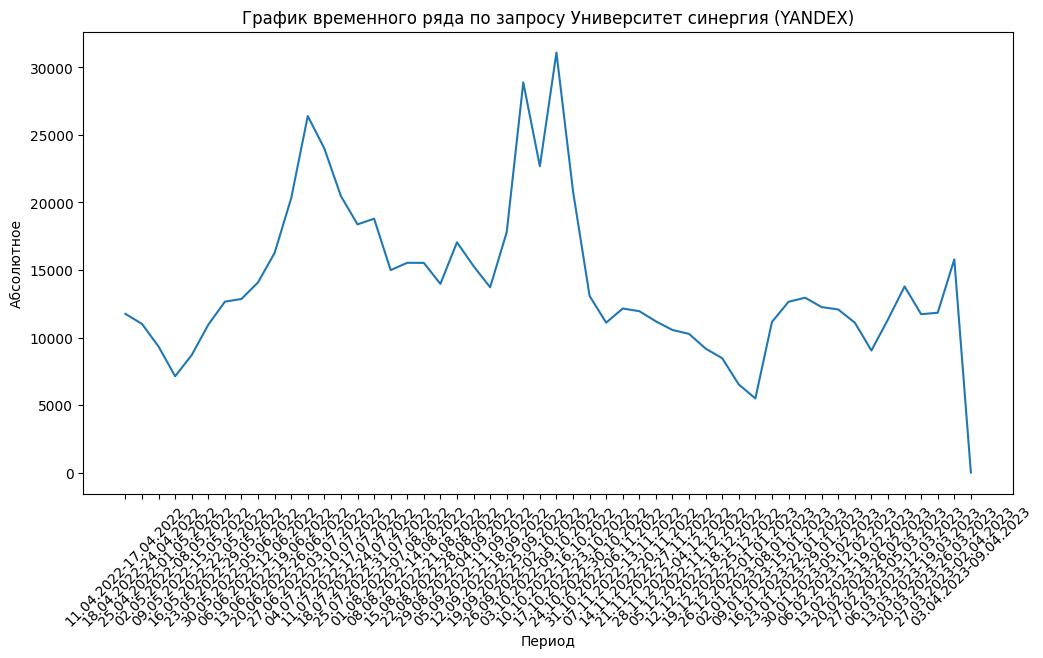

In [ ]:
#  график для Синергии
plt.figure(figsize=(12, 6))
plt.plot(yandex_synergy['Период'], yandex_synergy['Абсолютное'])
# меняем угол, чтобы все даты вместились
plt.xticks(rotation=45)
# добавляем заголовок и метки осей
plt.title('График временного ряда по запросу Университет синергия (YANDEX)')
plt.xlabel('Период')
plt.ylabel('Абсолютное значение')

plt.show()

In [ ]:
try:
    # Инициализируем объект Курсора, чтобы общаться с базой
    cursor = cnx.cursor()
    
    # Получаем данные из базы (локальной)
    query = """
    SELECT * FROM
        webscrapper.universities
    
    """
    cursor.execute(query)
except Exception as e:
    # логгируем ошибку подключения к БД
    logger.error(f"DB connect error: {e}")

In [ ]:
# Преобразуем ответ от базы в читаемый питоном вид
sql_data = list(cursor.fetchall())

In [ ]:
# проверка
sql_data[1][1]

'Университет Боккони'

In [ ]:
# Создаем пустой массив, чтобы потом в него записывать данные
kw_list = []

In [ ]:
# Смотрим на полученные университеты (которые мы анализировали)
for x in (sql_data):
    kw_list.append(x[1])
    print(x[0])
    selenium_scrapper(selenium_executor,x[0],yandex_login, yandex_password, yandex_data)

Гарвардский университет
Университет Боккони
Лондонская школа экономики и политических наук
Парижский институт политических исследований
Массачусетский технологический институт
Стэнфордский университет
Венский университет Экономики и Бизнеса
Университет Эразма Роттердамского
МГУ
МФТИ
 НИЯУ МИФИ
НИУ ВШЭ


In [ ]:
# Преобразуем в сжатый вид наш лист, чтобы построить график
kw_group = list(zip(*[iter(kw_list)]*1))
kw_grplist = [list(x) for x in kw_group]
trendshow = TrendReq(hl='en-US', tz=360)
dict = {}
i = 0
for kw in kw_grplist:
    trendshow.build_payload(kw, timeframe = 'today 12-m')
    dict[i] = trendshow.interest_over_time()
    i += 1

trendframe = pd.concat(dict, axis=1)
trendframe.columns = trendframe.columns.droplevel(0)
trendframe = trendframe.drop('isPartial', axis = 1)
trendframe



init_notebook_mode(connected=True)

trace = [go.Scatter(
x = trendframe.index,
y = trendframe[col], name=col) for col in trendframe.columns]

data = trace
layout = go.Layout(title='Относительная динамика популярности интернет-запросов исследуемых университетов за год', showlegend=True)
fig = go.Figure(data=data, layout=layout)
plt.figure(figsize=(20,13))
fig.add_vline(x='2022-09-01', line_dash='dash', line_color='black')
fig.add_vline(x='2023-05-01', line_dash='dash', line_color='black')
fig.add_vline(x='2022-07-25', line_dash='dash', line_color='black')
fig.add_vline(x='2022-06-20', line_dash='dash', line_color='black')
fig.add_vline(x='2023-01-05', line_dash='dash', line_color='black')

<Figure size 2000x1300 with 0 Axes>

Интерактивный график (прикрепила картинку, так как при сохранении в ipynb в гите график не отображался :(  однако в линамическом варианте его можно посмотреть и использовать если открыть файл dynamic.html -  там этот же график))


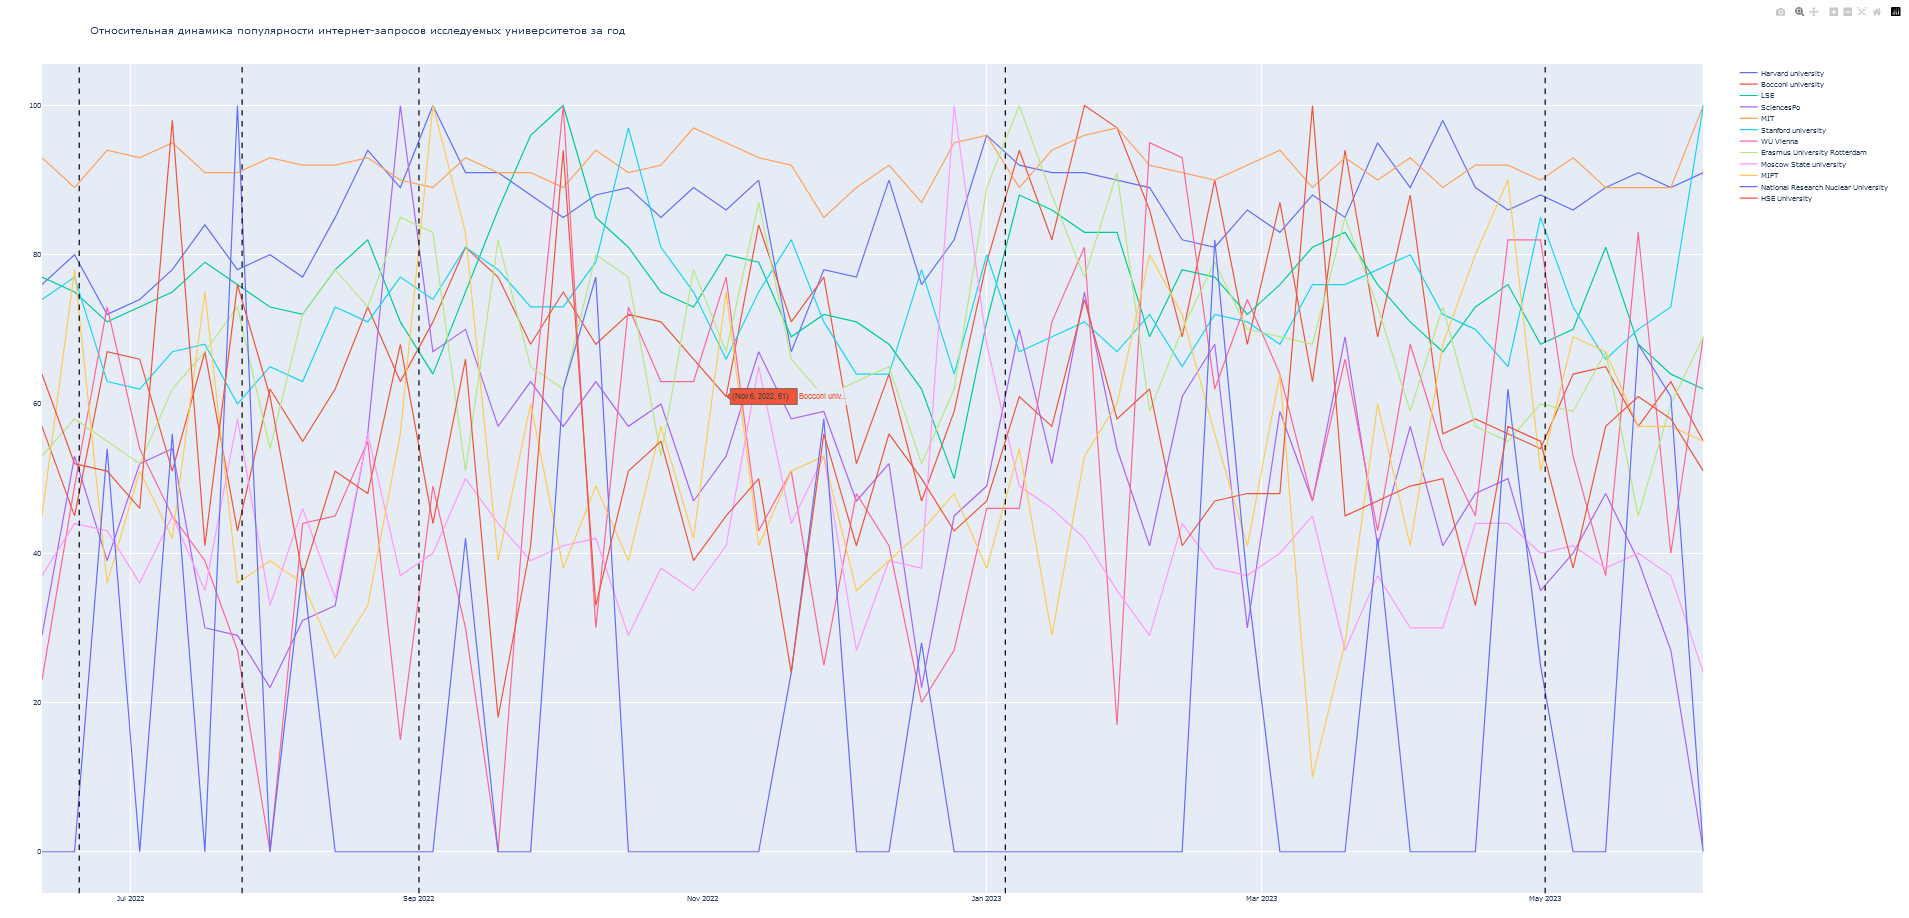

In [ ]:
from IPython.display import Image, display, HTML
print('Интерактивный график (прикрепила картинку, так как при сохранении в ipynb в гите график не отображался :(  однако в линамическом варианте его можно посмотреть и использовать если открыть файл dynamic.html -  там этот же график))')
Image("data.png", width=1800, height=800)

  На график нанесены ключевые даты для приемных кампаний исследуемых университетов (по порядку):


*   2022-06-20; дата начала приемной кампании в большинстве российских университетов на 2022-2023 уч.года

*   2022-07-25; дата окончания приемной кампании в большинстве российских университетов на 2022-2023 уч.года

*   2022-09-01; ориентировочная дата начала приемной кампании в большинство зарубежных университетов на 2023-2024 уч.года;  большинство западных университетов открывают набор в начале осени

*   2023-01-05; ориентировочная дата окончания приемной кампании в большинство топовых американских университетов на 2023-2024 уч.года (MIT, Stanford, Harvard)

*   2023-05-01; начало мая, то есть в России выпускные экзамены из школы, период ЕГЭ. Можно предположить, что многие проверяют свои баллы и мониторят сайты ВУЗов.









В итоге по графику видно (желательно открыть в HTML), что с июня по июль, во время кампании российских вузов, большие колебания наблюдаются именно у российских вузов, зарубежные колеблются не так сильно. Из российских университетов наименьшую амплитуду во время приемной кампании имеет МГУ. У него пик активности наблюдается 25 декабря 2022, а у остальных российских вузов именно в период приема, что объясняется постоянными проверками сайта для поиска актуальной информации о подачи документов.
Ближе всего к дедлайну подачи документов активность наблюдается у НИЯУ МИФИ, что может быть связано с непопулярностью университета и потенциальными студентами вуза, которые подают документы в последний момент, надеясь пройти в более престижные университеты. Остальные российские университеты более престижные, поэтому документы туда подаются как можно скорее и заранее, чтобы ничего не напутать.

По поводу зарубежных университетов можно сказать следующее:


1.   В некоторых университетах (Bocconi university, SciencePo) с сентября по январь не наблюдается большая амплитуда изменения запросов. Это может быть связано с тем, что у них другие даты кампаний (посмотрим позже)
2.   В тех университетах, где большая амплитуда (Stanford, LSE, WU Vienna) с сентября по январь, пик популярности наблюдается в первую волну подачи документов (обычно во всех топовых университетах подача идет в две или три волны), то есть люди переживают о своей заявке, хотят максимизировать шансы получить место в университете (не то что в МИФИ, где пик в предпоследний день подачи документов). 



Harvard university: Date of applying start: 2022-09-01, Date of applying end: 2023-01-01 


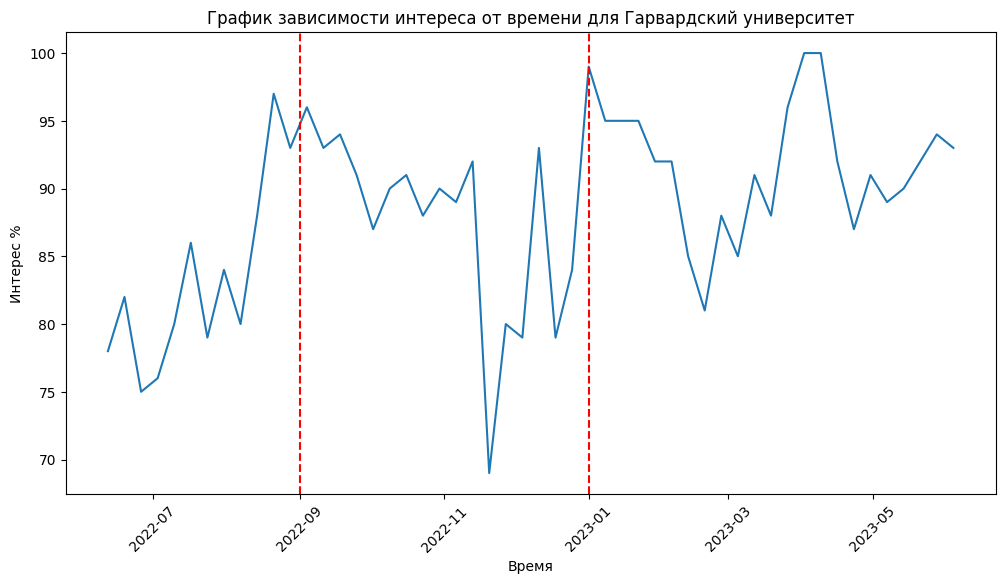

Bocconi university: Date of applying start: 2023-02-01, Date of applying end: 2023-04-19 


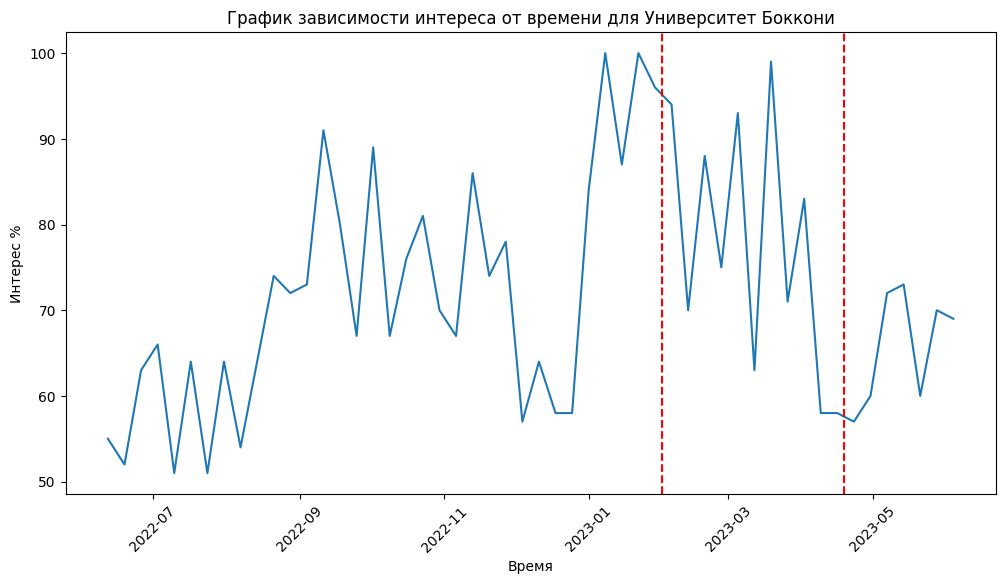

LSE: Date of applying start: 2022-09-01, Date of applying end: 2023-01-25 


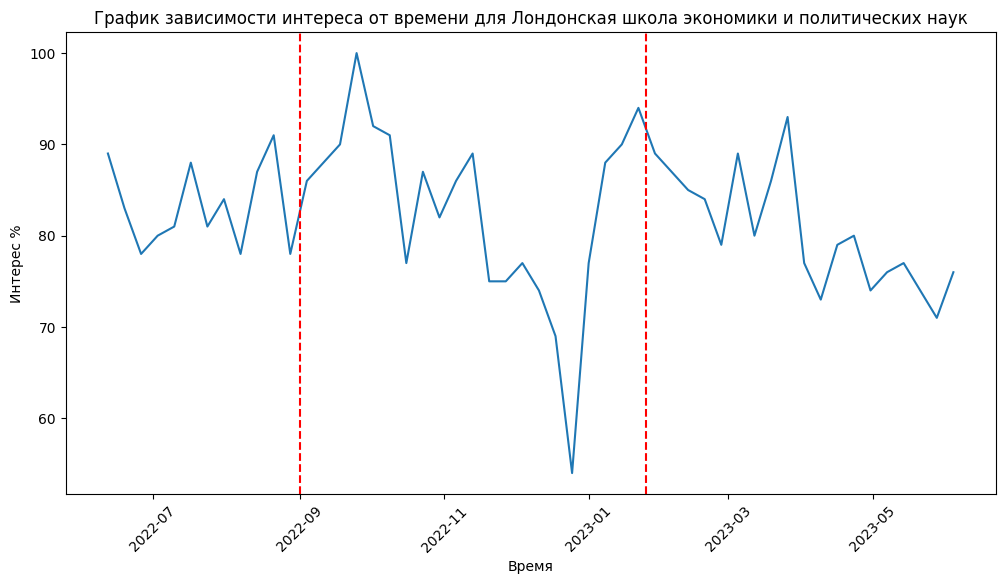

SciencesPo: Date of applying start: 2022-10-01, Date of applying end: 2023-02-26 


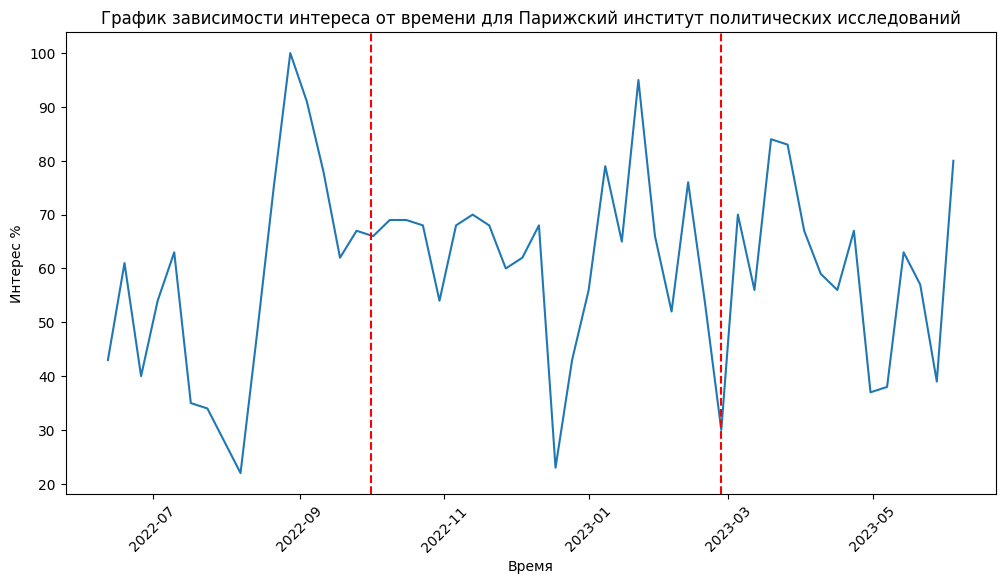

MIT: Date of applying start: 2022-09-01, Date of applying end: 2023-01-05 


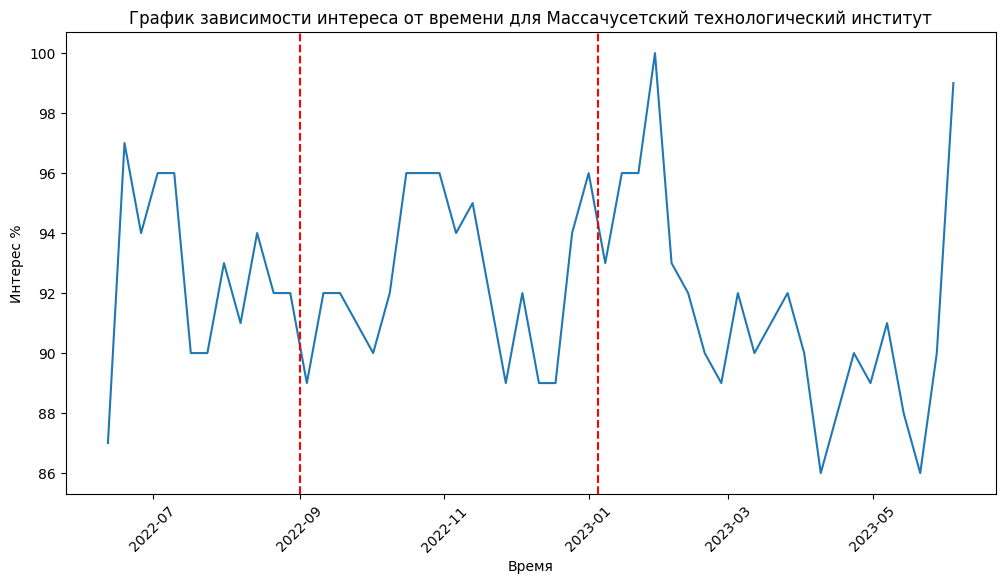

Stanford university: Date of applying start: 2022-09-15, Date of applying end: 2023-01-05 


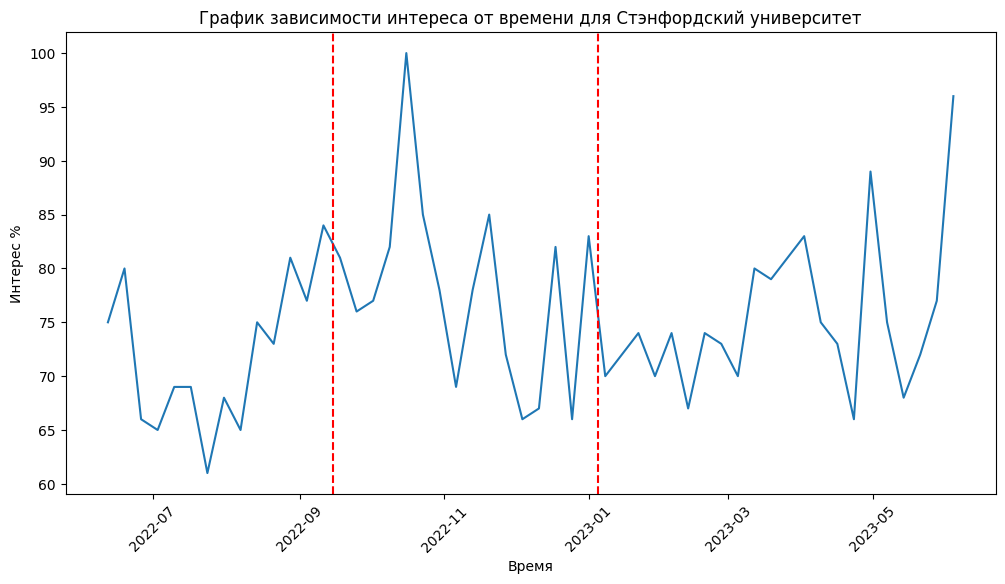

WU Vienna: Date of applying start: 2022-09-01, Date of applying end: 2023-01-08 


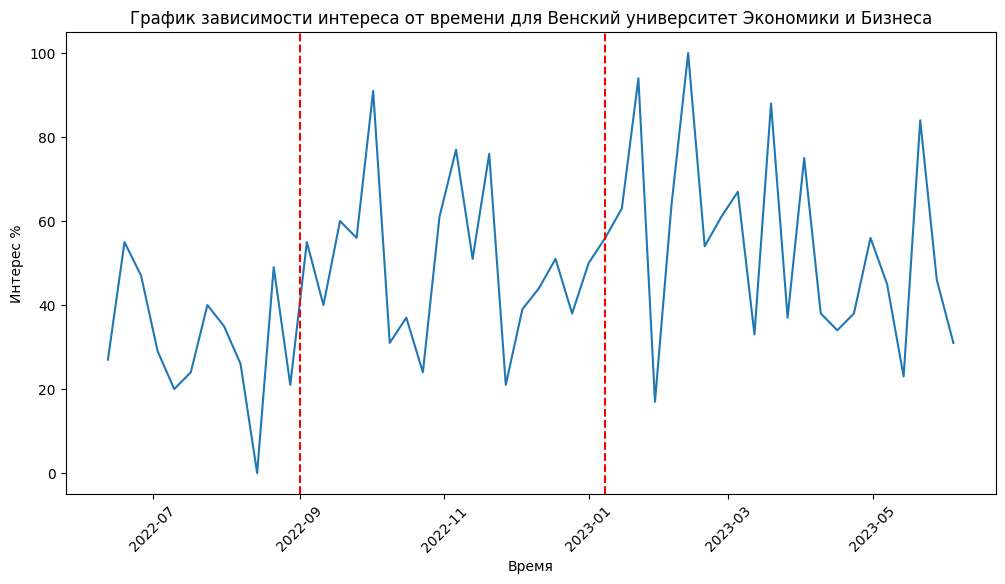

Erasmus University Rotterdam: Date of applying start: 2022-10-01, Date of applying end: 2023-05-01 


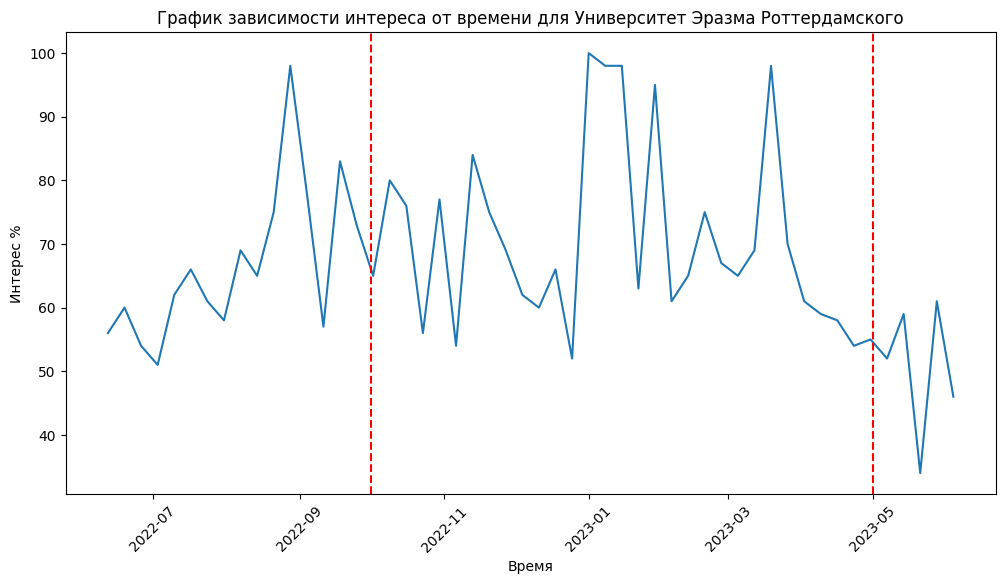

Moscow State university: Date of applying start: 2022-06-20, Date of applying end: 2022-07-10 


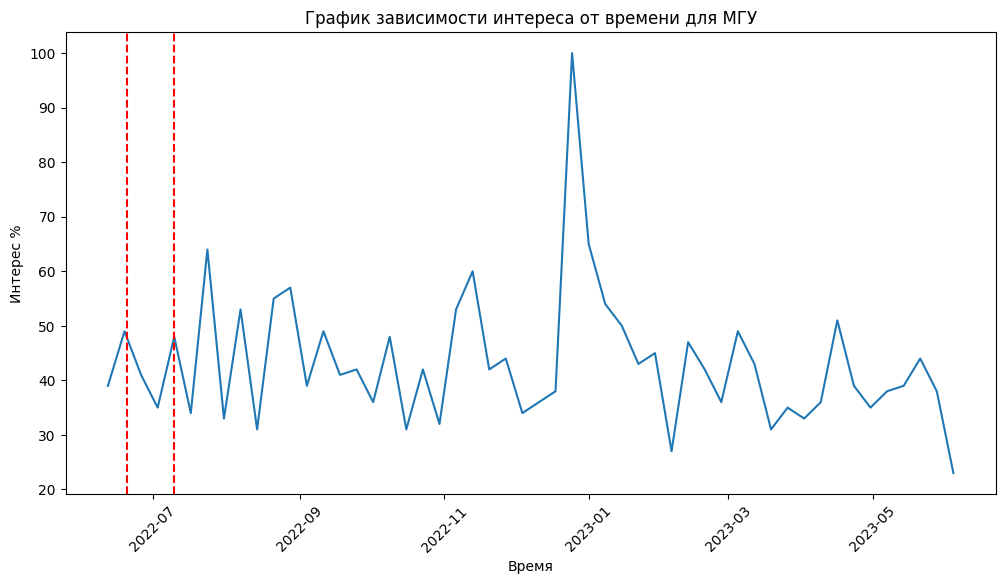

MIPT: Date of applying start: 2022-06-20, Date of applying end: 2022-08-05 


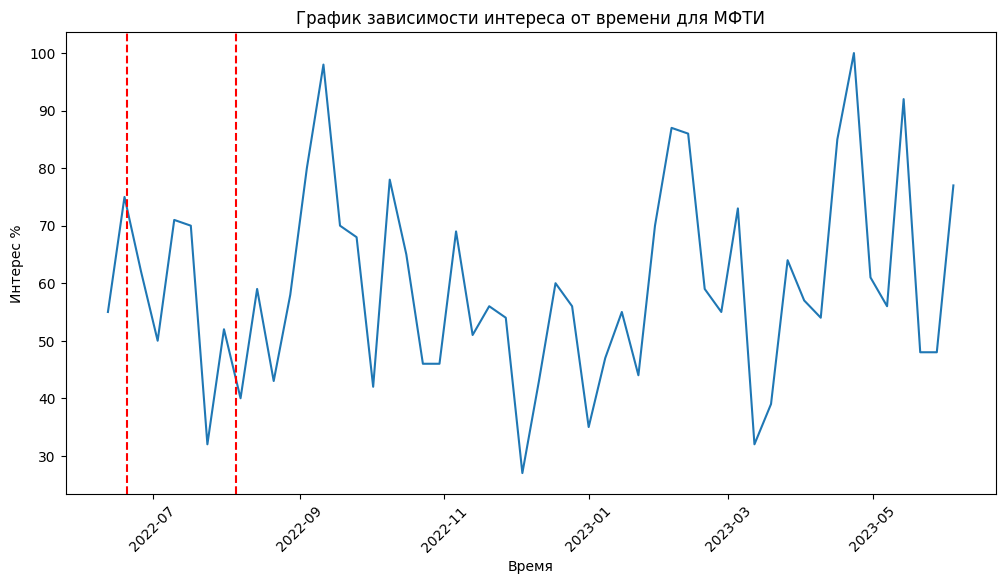

National Research Nuclear University: Date of applying start: 2022-06-15, Date of applying end: 2022-07-25 


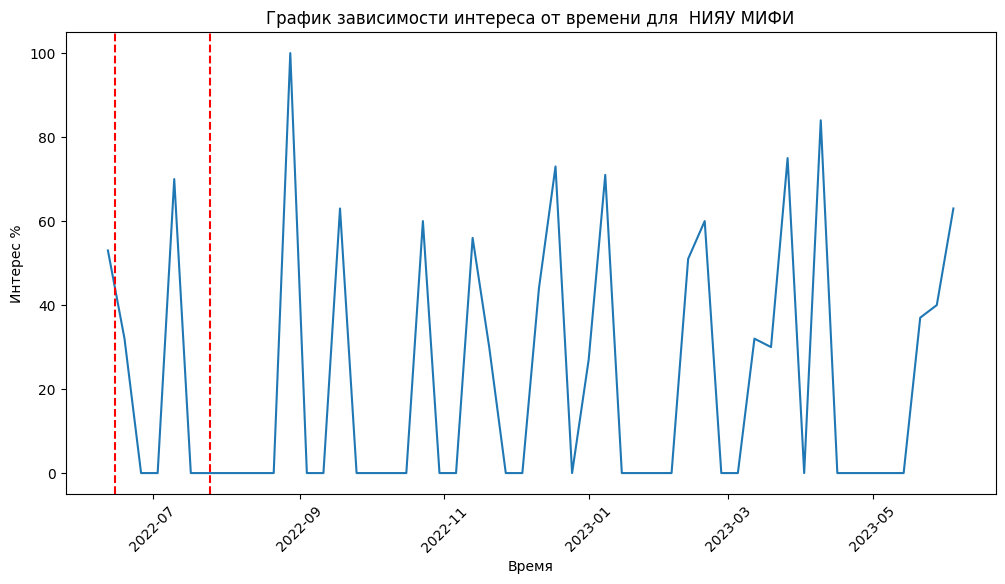

HSE University: Date of applying start: 2022-06-20, Date of applying end: 2022-07-25 


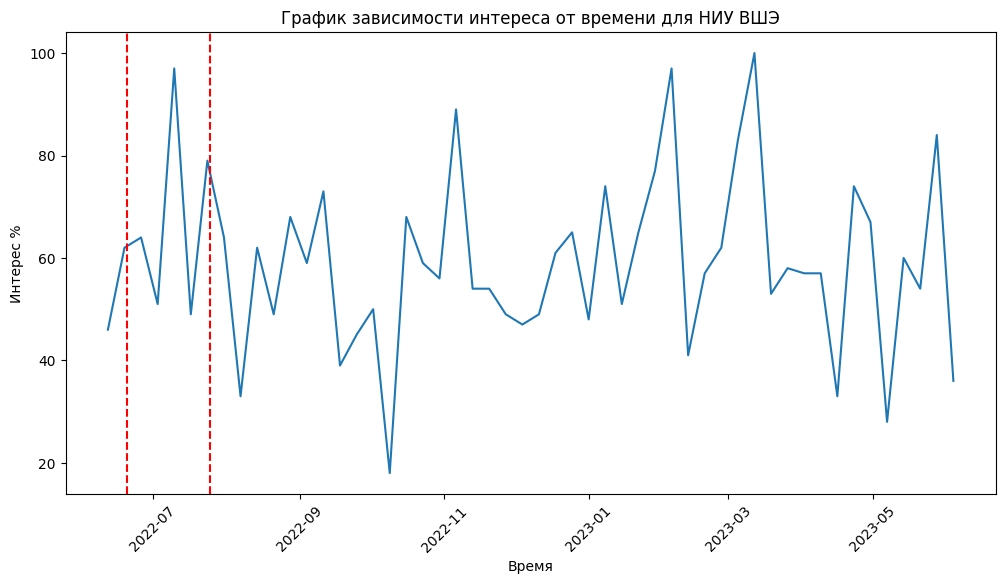

In [ ]:
# Нарисуем графики по-отдельности для разных университетов
for item in (sql_data):
    print(F"{item[0]}: Date of applying start: {item[3]}, Date of applying end: {item[4]} ")
    pytrends = TrendReq()
    pytrends.build_payload(kw_list=[item[0]], timeframe = 'today 12-m')
    interest_over_time_df = pytrends.interest_over_time()
    # Выведем дата-фрейм, полученный по запросу
    interest_over_time_df["date_helper"] = interest_over_time_df.index.date
    plt.figure(figsize=(12, 6))
    plt.plot(interest_over_time_df["date_helper"], interest_over_time_df[item[0]])
    plt.xticks(rotation=45)
    # Мини костыль была вынуждена применить чтобы обработать данные от Гугл
    plt.axvline(dt.datetime(int(item[3][0:4]), int(item[3][5:7]), int(item[3][8:10])), color ='red', linestyle='--')
    plt.axvline(dt.datetime(int(item[4][0:4]), int(item[4][5:7]), int(item[4][8:10])), color ='red', linestyle='--')

    plt.title(f'График зависимости интереса от времени для {item[1]}')
    plt.xlabel('Время')
    plt.ylabel('Интерес %')
    plt.show()
    # Спим, чтобы Гугл не забанил
    time.sleep(3)

**Комментарии по поводу графиков выше:**

**1)	Гарвардский университет**

Неочевидная динамика заключается в том, что в конце ноября резкий спад активности. Возможно, это связано с праздником Thanksgiving day 24-25 ноября 2022 года. В этот период, должно быть, все собираются семьями отдыхать и перестают мониторить сайт Гарварда, однако уже ближе к дедлайну подачи (1 января) активность резко растет, так как все подают заявки. Аналогичный спад активности наблюдается в конце декабря на Рождество (25 декабря), однако спад не такой большой, возможно, потому что уже времени до конца подачи не остается. Отметим, что активность весь год остается рекордно большой (около 75% от максимума), что выделяет Гарвард от других университетов и показывает, что он один из топовых в мире.

**2)	Университет Боккони**

На протяжении приемной кампании, которая длится 2,5 месяца, сохраняется стабильно высокий интерес к сайту университета, но большой всплеск активности наблюдается прямо до начала кампании, то есть видимо люди знают даты приемной кампании и готовятся заранее, а потом только отправляют заявку. Это может судить о высоком уровне университета.

**3)	Лондонская школа экономики и политических наук**

Максимум активности за год достигается как раз в приемную кампанию (где-то в начале октября), возможно потому что люди смотрят точные сроки дедлайнов с наступлением осени и учебного года. На спад в конце декабря снова не обращаем внимания, так как там Рождественские праздники. Под конец applying period активность около 95%, то есть многие тянут и подают документы в последний момент.

**4)	Парижский институт политических исследований**

Рекордный результат активности достигается в августе, возможно как и с LSE, люди заранее смотрят даты приемной кампании грядущего года (их публикуют как раз с началом осени). На протяжении кампании интерес остается стабильным с упадком в конце декабря и ростом интереса ближе к дедлайну. Также интересно, что ответы по заявкам абитуриентам приходят равномерно, то есть большой всплеск в конце января может быть обусловлен не только тем, что многие подают документы, но также и тем, что многим приходят ответы и они заходят на сайт смотреть решение комиссии. 

**5)	Массачусетский технологический институт**

Сразу стоит сказать, что данный график для MIT не совсем репрезентативный и дальше мы поймем, почему. По сути тут грязные данные, поэтому график не отражает реальную ситуацию. Оно и видно: пик активности после дедлайна подачи. Такого не было ни у одного университета и это странно. Все потому что тут график не для университета MIT на самом деле.

**6)	Стэнфордский университет**

Пик достигается в первую волну подачи документов. Все хотят максимизировать свои шансы в Стэнфорд и готовятся заранее :) во вторую волну (после октября) тоже многие подаются или гуглят правила приема и нужные документы, так как активность 85% сильно выше, чем в НЕ applying period 65%. Нужно еще отметить всплеск активности в мае: 1 мая в Стэнфорде Student Reply Date, то есть когда студенты должны ответить университету, принимают ли они приглашение об учебе или нет. 

**7)	Венский университет Экономики и Бизнеса**

Здесь нужно сказать, что в Венском Экономическом университете набор на программы ведется два раза в год: на осенний и весенний семестр, поэтому прием ведется практически нон-стоп. На графике показан промежуток приема на весенний семестр. Он не такой популярный, как осенний семестр, тем не менее видна динамика, что в эти даты активность выше, чем летом.

**8)	Университет Эразма Роттердамского**

Активность резко возрастает после рождественских праздников и в марте за месяц до дедлайна подачи. Заявки тоже подаются в несколько волн, здесь обе волны одинаково популярны.

**9)	МГУ**

Для МГУ результат получился очень странным. На графике обозначены даты приемной кампании для не БВИ-шников. Возможно такое падение популярности говорит о том, что в МГУ поступает большое количество БВИ-шников, для которых волна подачи сразу после отмеченного периода и там наблюдается небольшой подъем. Однако все равно непонятно, почему такая маленькая активность в приемную кампанию.

**10)	МФТИ**

Для МФТИ результат следующий: прямо перед приемом документов рост активности, как и в предыдущих случаях. В целом во время кампании не очень высокая активность. Это связано в первую очередь с тем, что в МФТИ очная подача документов, а не через сайт, поэтому все делается через звонки телефона и личное присутствие, а не через сайт. То же самое верно для МГУ выше. 

**11)	НИЯУ МИФИ**

Для МИФИ уже все было написано выше: в течение года практически нулевое посещение сайта, что неверно ни для одного университета выше. Во время приёмной кампании всплеск активности совсем близко к дедлайну. Далее всплеск активности в конце лета, возможно это результаты и списки поступления выкладывают.

**12)	НИУ ВШЭ**

Для НИУ ВШЭ понятная динамика: резкий скачок гугл запросов во время приемной кампании, почти максимум от совокупных запросов. Остальные скачки запросов в феврале можно объяснить выкладыванием рейтинга за прошедший семестр и другими мероприятиями, которые регулярно проходят в Вышке.


Далее выведем гео-графики по запросам университетов выше.

%%html
<div style="background-color: #f2f2f2; padding: 20px; font-size: 24px;">
Так как объект карты в рамках одной ячейки не дает вырисовать много отдельных карт, то нарисуем их все по отдельности
</div>

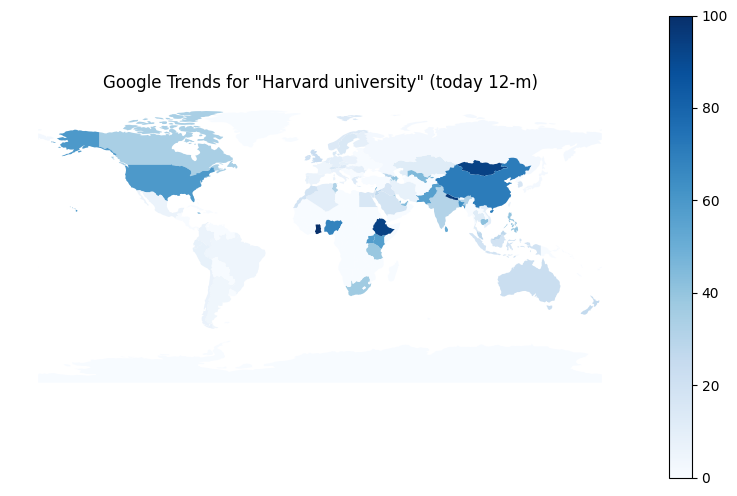

In [ ]:
# Выставляем временной промежуток, за который мы хотим получить данные по АПИ
timeframe = 'today 12-m'
# Инициализируем массив данных
keyword = sql_data[0][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
# Меняем название некоторых стран, так как в датасете геопандас они называются по-другому
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

Гарвард популярен по всему миру, особенно в Китае и конечно в США. Судя по этому и следующим графикам на Россию стоит какой-то блок. Не очень верится, что Гарвард в России гуглят меньше, чем в Казахстане или Монголии.

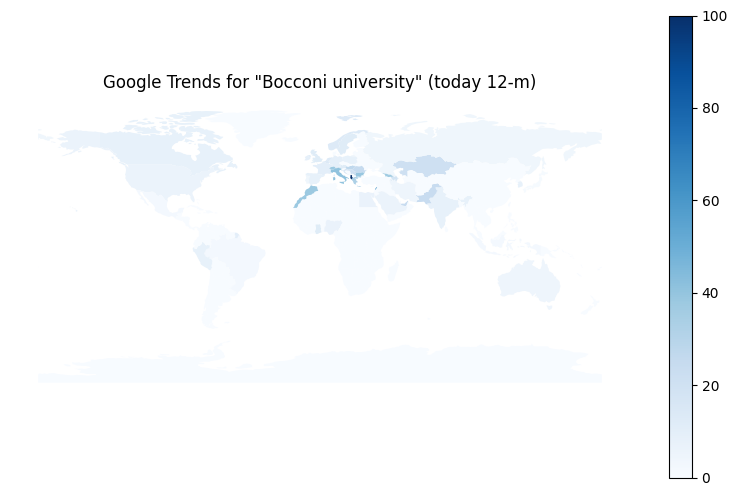

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[1][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

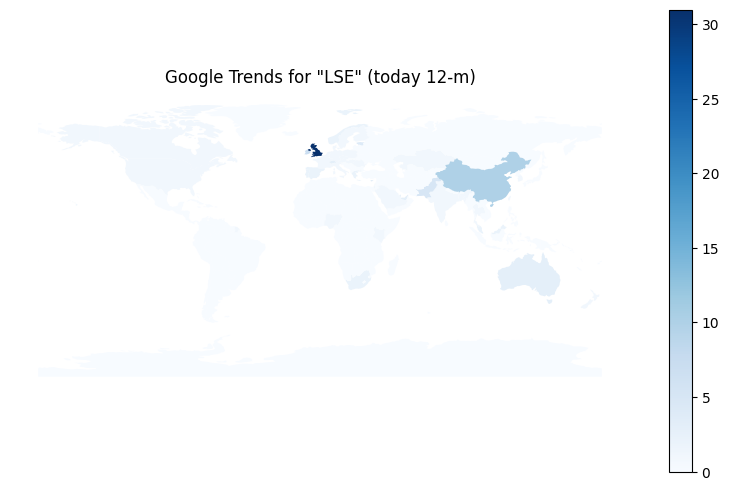

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[2][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

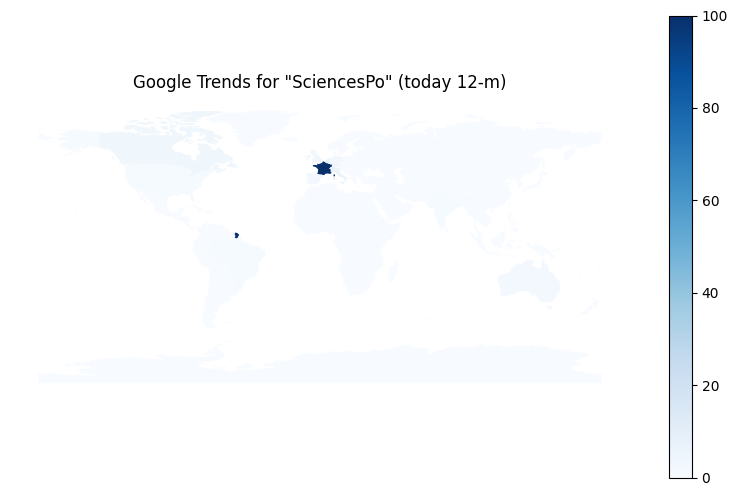

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[3][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

Из графиков выше видно, что из проанализируемых европейских университетов активнее всего гуглят Bocconi. Также можно сказать, что эти университеты популярны практически только в своих же странах. Для сравнения -- карта для Гарварда и Стэнфорда.

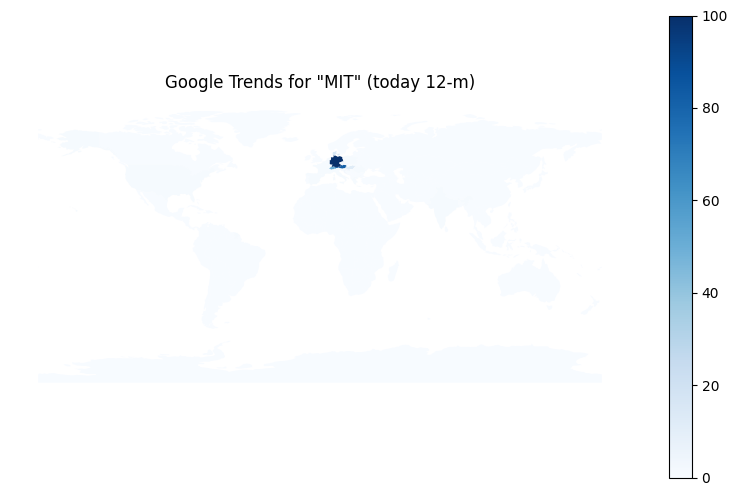

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[4][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

Выглядит странно, что MIT больше всего гуглят в Германии, близлежащей Швейцарии и Австрии, но не гуглят в США или Китае, как другие крупные американские университеты. На самом деле это очень интересно, потому что "mit" в немецком то же самое, что "with" в английском. Получилось, что в немецкоговорящих странах это слово-предлог гуглят настолько чаще, чем название университета MIT в других странах, что и получилась такая процентная динамика.

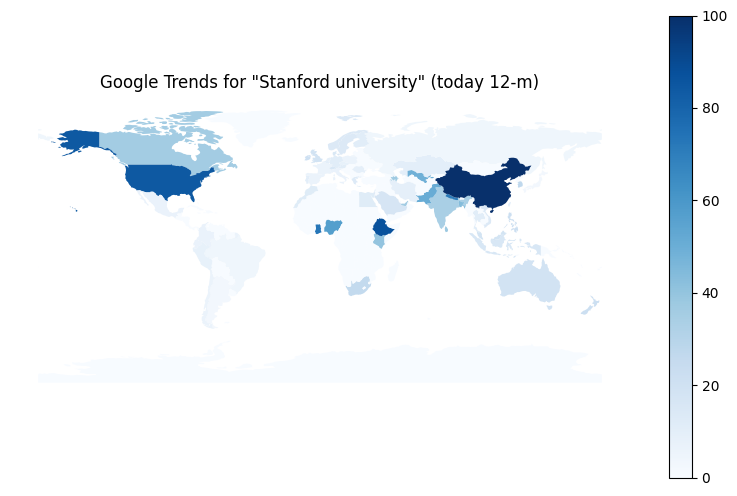

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[5][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

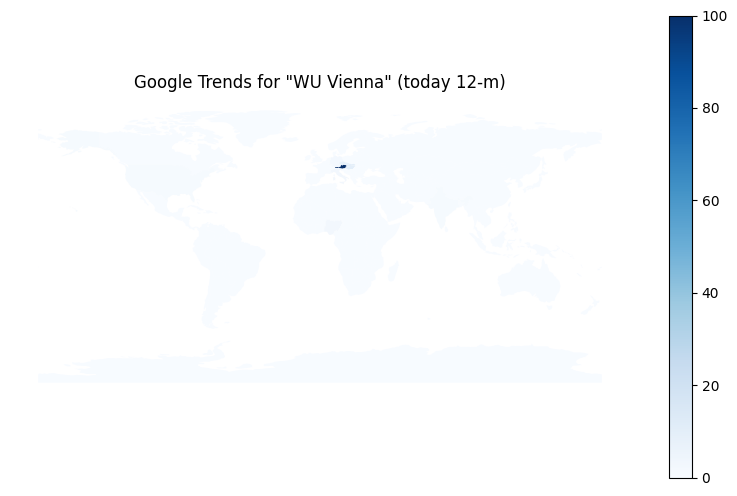

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[6][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

Венский университет больше всего гуглят в Австрии, что подтверждает предыдущую динамику европейских университетов.

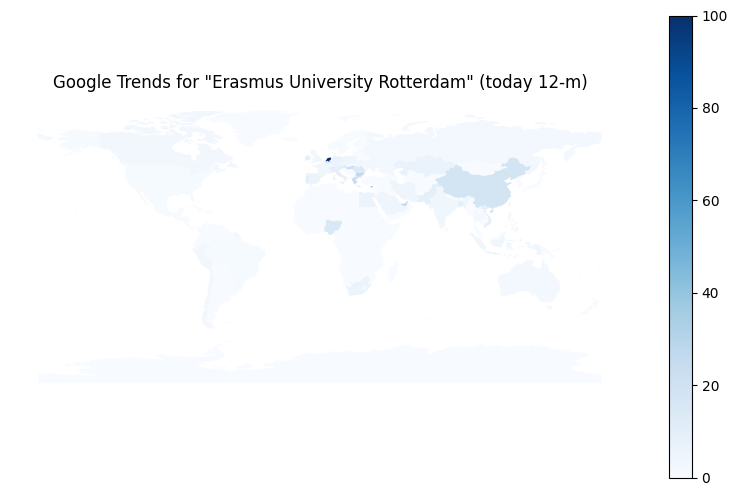

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[7][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

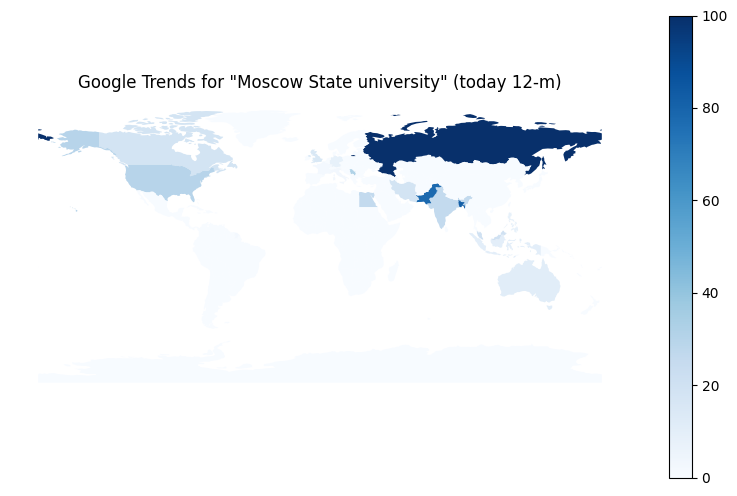

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[8][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

МГУ много гуглят очевидно в России, а также неожиданно в США. Возможно это потому что многие туда едут работать и работодатели гуглят университет кандидата при устройстве на работу.

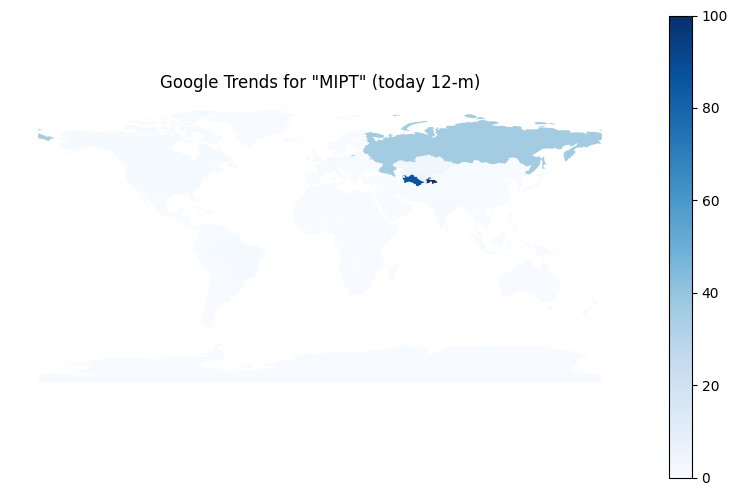

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[9][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

Помимо России много запросов из Таджикистана и Туркменистана. Видимо оттуда много кто поступает в МФТИ.

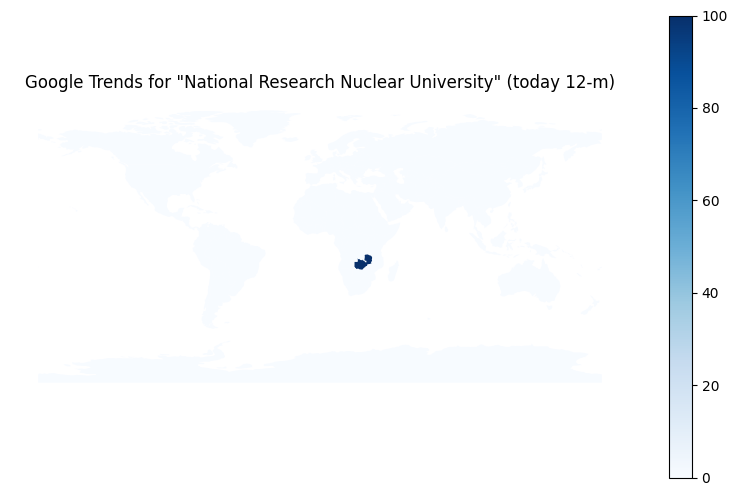

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[10][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

На карте сильно выделена Замбия. На сайте университета указано, что у них много студентов оттуда, поэтому такая динамика.

Интересная статья с пруфами (спойлер: половина МИФИ видимо из Замбии):
https://www.miningreview.com/news/students-zambia-nuclear-science-russia/?amp=1

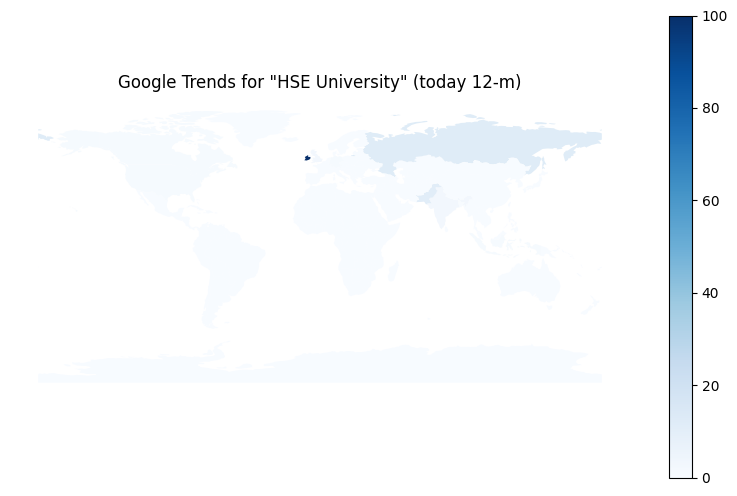

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[11][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

Жирно выделенный кусочек - это Ирландия. В ней есть компания по предоставлению медицинских услуг Health Service Executive (сокращенно HSE), поэтому там много запросов по HSE.

In [ ]:
# закрываем коннект к БД
cursor.close()
cnx.close()

Судя по проведенному анализу, можно сказать, что гипотеза подтвердилась частично:


*   Во время приемной кампании в любом университете (кроме нерепрезентативного MIT) наблюдается острый пик популярности, чаще всего в середине приема документов
*   Однако не всегда на момент начала приемной кампании динамика возрастающая, есть случаи, когда наоборот резкий рост популярности запросов перед началом приемной кампании. Обычно это верно для топовых университетов в отдельной стране. 

В течение проекта я столкнулась с проблемой одноименных организаций, которые портят реальную картину мира, и это очень видно на гео-графиках. С такой проблемой нужно как-то справиться при дальнейшей разработке этого проекта, например добавить ключевые слова "студент" или "учеба". В таком случае, например медицинская организация HSE из Ирландии отфильтровалась бы. 

Также картину портит то, что в течение подачи документов некоторым людям приходят уже ответы по ранним заявкам, и это увеличивает активность.



Выводы:

1) Американские университеты являются самыми популярными в Сети, значит постоянно на слуху и скорее всего из этого можно сделать вывод, что они самые востребованные и топовые.

2) Динамика нагрузки на мощности и человеческий капитал университетов разнится, но кажется, что можно делать прием заявок всего в две волны (а не в пять, как у SciencePo) с большим упором мощностей на первую волну.

3) Американские университеты популярны во многих странах (Китай, Канада, Индия, США и тд), но в Европе не особо. В Европе больше гуглят европейские университеты, особенно непосредственно своей страны.

4) К концу приемной кампании обычно поток заявок будет расти, так как всплеск гугл-запросов ближе к концу, а значит заявку отправят еще позже (пока заполнят документы, все проверят, и тд)